In [1]:
# loading libraries
library(tidymodels)
library(tidyverse)
library(tidyclust)
library(forcats)
library(repr)
library(GGally)
# specify the width and height of the graph
options(repr.matrix.max.rows=6)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conf

## Behavioral Predictions of Newsletter Subscription Across Different  Players Types

A group of researchers is interested in collecting data on how individuals engage with video games. To support their investigation, they have a MineCraft server to record players' action as they navigate through the world. However, serveral important considerations has to be addressed to ensure the successful execution of the research. This project aims to explore the following question: How does a individual's experience and gender influence the likelyhood of subscribing to a newsletter in `players.csv`?

To begin with, we start by investigating the data set `players.csv` that will be used to explore the question. The data set is collected from a online MineCraft server created by a research group in UBC. 

In [2]:
players_data <- read_csv("data/players.csv")
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


The data set above has 7 variables, which are: `experience`, `subscribe`,`hashedEmail`,`played_hours`,`name`,`gender`, and `age`. There are 196 observations, thus 196 individuals participated to the collection of the data. The meaning of each variable is presented below.
* `experience`: the player's experience level in MineCraft
* `subscribe` : the player subscribed to a newsletter or service
* `hashedEmail`: a hashed version of the player's email address
* `played_hours` :total number of hours the player has spent playing on MineCraft server
* `name` : the player's name
* `gender` : the player's self-reported gender
* `age` : the player's self-reported or estimated age

There are some problems in this data set, such as the variable `play_hours` has an underscore, the `Age` is double and capitalized.

## Data Processing and Analysis
We will start the analysis by selecting the variables for the question, which is `experience`, `subscribe`, and `gender`. From the data set above, `experience` is expressed as a charater, thus for future analysis we will change it to a factor, allowing us to plot experience as a group.

In [4]:
players <- players_data|>
    select(experience, subscribe, gender)|>
    mutate(experience=as_factor(experience))|>
    mutate(gender=as_factor(gender))

players

experience,subscribe,gender
<fct>,<lgl>,<fct>
Pro,TRUE,Male
Veteran,TRUE,Male
Veteran,FALSE,Male
⋮,⋮,⋮
Amateur,FALSE,Prefer not to say
Amateur,FALSE,Male
Pro,TRUE,Other


It is hard to determine the relationship in a data table, therefore we will plot a bar plot to help us understand the relationship between the variables that we are interested in.

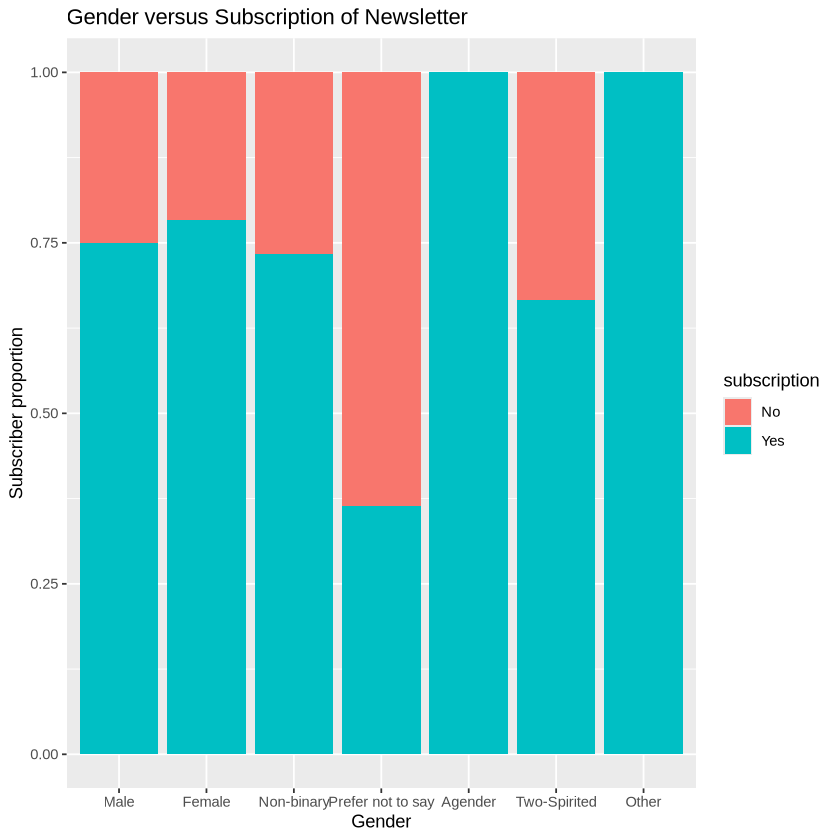

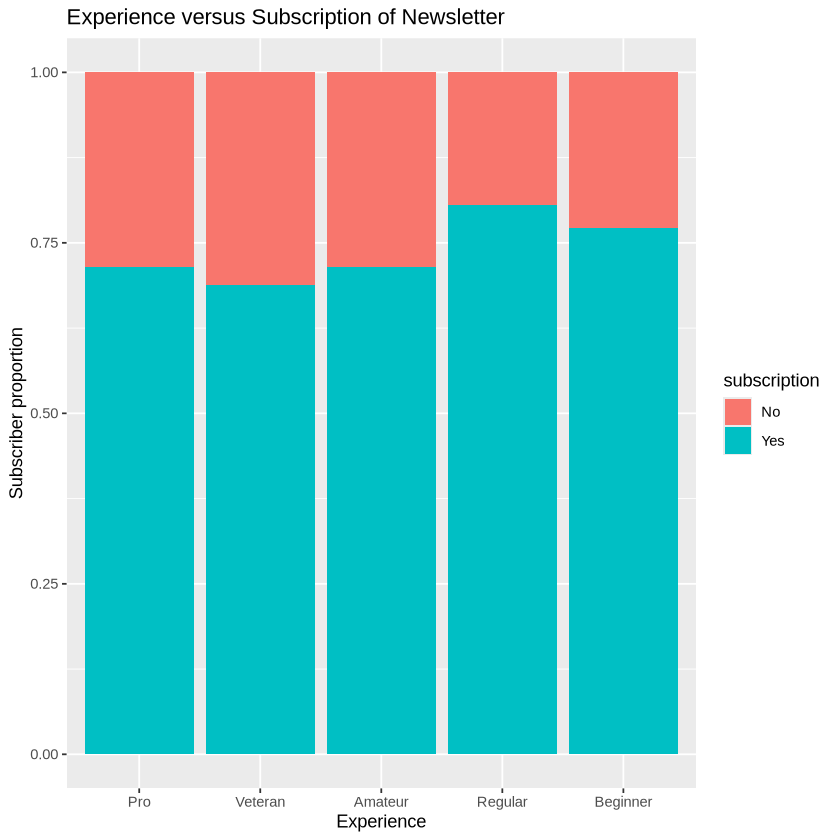

In [5]:
gender_bar <- players|>
    ggplot(aes(x= gender, fill=subscribe))+
    geom_bar(position="fill")+
    labs(x="Gender", y= "Subscriber proportion", fill="subscription")+
    ggtitle("Gender versus Subscription of Newsletter")+
    scale_fill_discrete(labels=c("No", "Yes"))

experience_bar <- players|>
    ggplot(aes(x= experience, fill=subscribe))+
    geom_bar(position="fill")+
    labs(x="Experience", y= "Subscriber proportion", fill="subscription")+
    ggtitle("Experience versus Subscription of Newsletter")+
    scale_fill_discrete(labels=c("No", "Yes"))

gender_bar
experience_bar

The two plots gave a reasonably different results. The first plot shows that individuals that identify themselves as agender and other has 100% subscribtion, and people who identify themselves as female, male, non-binary, two-spirited have roughly 75% subscription. However, those who prefer not to say has a significantly low percentage of subscriptions. 
The second plot shows that experience barely has any correlationship with subscription, since all levels of experience showed around 75% of subscriptions.

Now, we will analyse data using K-NN classification since we want to predict if experience and gender affects the subscription of player, which is a binary classification problem. Although there are some issues we need to fix before perorming data analysis. K-NN classification uses distance calculations, thus, categorical variables such as `experience` and `gender` has to converted into numeric variables.

In [26]:
players <- players|>
    mutate(experience_num=as.numeric(factor(experience)))|>
    mutate(gender_num=as.numeric(factor(gender)))|>
    mutate(subscribe=as_factor(subscribe))
players

experience,subscribe,gender,experience_num,gender_num
<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,TRUE,1,1,1
2,TRUE,1,2,1
2,FALSE,1,2,1
⋮,⋮,⋮,⋮,⋮
3,FALSE,4,3,4
3,FALSE,1,3,1
1,TRUE,7,1,7


In [27]:
players_knn <- players|>
    select(experience_num, gender_num, subscribe)
players_knn

experience_num,gender_num,subscribe
<dbl>,<dbl>,<fct>
1,1,TRUE
2,1,TRUE
2,1,FALSE
⋮,⋮,⋮
3,4,FALSE
3,1,FALSE
1,7,TRUE


In [28]:
set.seed(2000)
players_split <- initial_split(players, prop=0.7)
players_train <- training(players_split)
players_test <- testing(players_split)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5901913,5,0.03896368,Preprocessor1_Model1
2,accuracy,binary,0.6187627,5,0.04684023,Preprocessor1_Model2
3,accuracy,binary,0.6668498,5,0.06943204,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,accuracy,binary,0.6871998,5,0.03958875,Preprocessor1_Model7
8,accuracy,binary,0.7454009,5,0.02834032,Preprocessor1_Model8
9,accuracy,binary,0.7602361,5,0.02755446,Preprocessor1_Model9


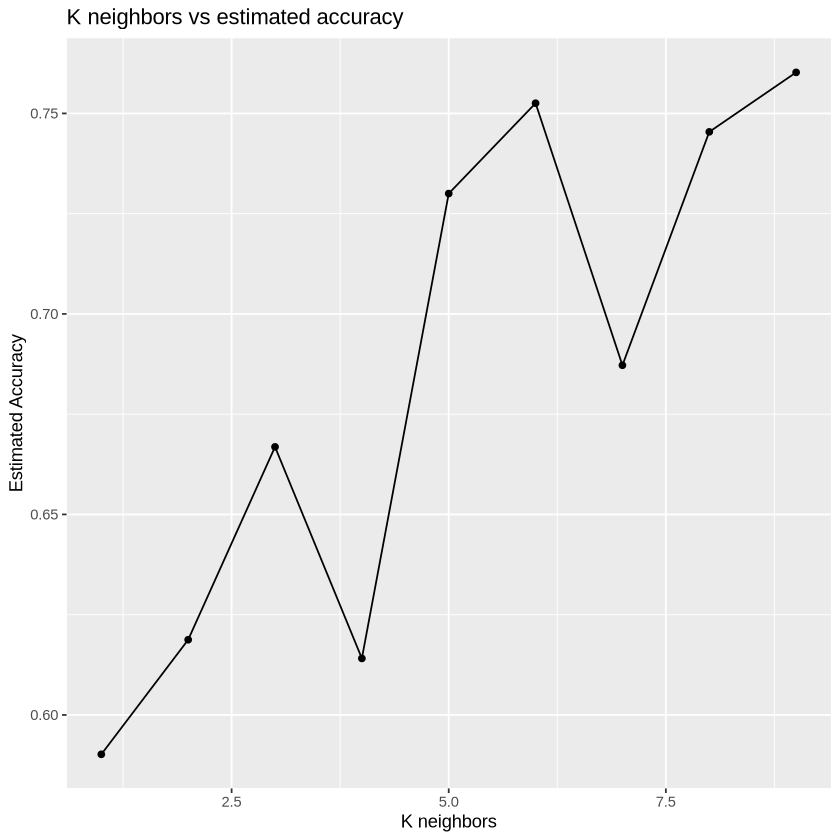

In [42]:
players_recipe <- recipe(subscribe~ gender_num+experience_num, data=players_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors= tune())|>
    set_engine("kknn")|>
    set_mode("classification")

train_vfold <- vfold_cv(players_train, v=5, strata= subscribe)

k_vals <- tibble(neighbors=seq(from=1, to=9))

knn_results <- workflow()|>
    add_recipe(players_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=train_vfold,grid=k_vals)|>
    collect_metrics()|>
    filter(.metric=="accuracy")

accuracy_plot <- ggplot(knn_results, aes(x=neighbors, y= mean))+
    geom_point()+
    geom_line()+
    labs(x="K neighbors", y="Estimated Accuracy")+
    ggtitle("K neighbors vs estimated accuracy")

# knn_fit <- workflow()|>
#     add_recipe(players_recipe)|>
#     add_model(knn_spec)|>
#     fit(data=players_train)

knn_results
accuracy_plot

In [52]:
players_spec <- nearest_neighbor(weight_func="rectangular", neighbors=5)|>
    set_engine("kknn")|>
    set_mode("classification")

players_fit <- workflow()|>
    add_recipe(players_recipe)|>
    add_model(players_spec)|>
    fit(data=players_train)

players_test_preds <- predict(players_fit, players_test)|>
    bind_cols(players_test)|>
     metrics(truth=subscribe, estimate= .pred_class)|>
    filter(.metric == "accuracy")
   
players_preds
players_test_preds

.pred_class,experience,subscribe,gender,experience_num,gender_num
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
TRUE,4,TRUE,1,4,1
TRUE,3,FALSE,1,3,1
TRUE,3,TRUE,1,3,1
⋮,⋮,⋮,⋮,⋮,⋮
TRUE,1,FALSE,1,1,1
TRUE,3,FALSE,1,3,1
TRUE,3,TRUE,2,3,2


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6779661
